# Are we consuming more local?

## Research questions

1. Where are the products we consume in our everyday life coming from?

    - Which countries produce the primary resources (ground ingredients) consumed in Switzerland?
    - Which countries manufacture most of the products consumed in Switzerland?


2. Is there a trend over time to consume more local products?

    - Are new products mostly using primary resources from Switzerland? Or from other countries inside Europe?
    - Are new products mostly manufactured in Switzerland? Or from other countries inside Europe?
    - Is there a trend over time to local products to promote their origin?

## Datasets

Open Food Facts (https://world.openfoodfacts.org/data)

Additional datasets “Evolution de la consommation de denrées alimentaires en Suisse” (https://opendata.swiss/fr/dataset/entwicklung-des-nahrungsmittelverbrauches-in-der-schweiz-je-kopf-und-jahr1) and “Dépenses fédérales pour l’agriculture et l’alimentation” (https://opendata.swiss/fr/dataset/bundesausgaben-fur-die-landwirtschaft-und-die-ernahrung1) from https://opendata.swiss/fr/group/agriculture

A last additional dataset for the second question of the project
https://www.gate.ezv.admin.ch/swissimpex/public/bereiche/waren/result.xhtml
Total of imports of agriculture, forestry and fishing goods


In [1]:
#imports
import re
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
import findspark
findspark.init()
import pyspark

from functools import reduce
from pyspark.sql import *
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.functions import to_date, last_day,date_add
from datetime import timedelta

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [3]:
DATA_FOLDER = 'data'
openfood_file = "/en.openfoodfacts.org.products.csv"

# Loading data

In [10]:
dataset_main = spark.read.csv(DATA_FOLDER+ openfood_file, header=True, mode="DROPMALFORMED", sep = '\t')

dataset_main.createOrReplaceTempView("data_main")

# Filter required columns
p_id_col = " code, "
general_cols = " brands, brands_tags, categories, categories_tags, origins, origins_tags, manufacturing_places, manufacturing_places_tags,labels,labels_tags,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags "
geo_cols = " origins, manufacturing_places, countries "
geo_tags_cols = " origins_tags, manufacturing_places_tags, countries_tags "

off_df = spark.sql("SELECT" + p_id_col + geo_cols + "," + geo_tags_cols + " FROM data_main")
off_df.printSchema()

root
 |-- code: string (nullable = true)
 |-- origins: string (nullable = true)
 |-- manufacturing_places: string (nullable = true)
 |-- countries: string (nullable = true)
 |-- origins_tags: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- countries_tags: string (nullable = true)



In [11]:
off_all_size = off_df.count()
off_cols_size = len(off_df.columns)
print("All data Size:\n" + str(off_cols_size) + "(columns) * " + str(off_all_size) + "(rows)")

All data Size:
7(columns) * 693829(rows)


### Data Cleaning and Preprocessing

In [6]:
# Find number of missing data

off_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in off_df.columns]).show()

+----+------------+-------+--------------------+---------+------------+-------------------------+--------------+
|code|product_name|origins|manufacturing_places|countries|origins_tags|manufacturing_places_tags|countries_tags|
+----+------------+-------+--------------------+---------+------------+-------------------------+--------------+
|   0|       25982| 651635|              626848|      561|      651689|                   626868|           561|
+----+------------+-------+--------------------+---------+------------+-------------------------+--------------+



In [21]:
off_df.createOrReplaceTempView("off_df")

sql_filter = "SELECT * FROM off_df WHERE countries is not NULL \
              AND countries_tags is not NULL \
             AND origins is not NULL AND origins_tags is not NULL AND\
             manufacturing_places is not NULL AND manufacturing_places_tags is not NULL "

off_p_df = spark.sql(sql_filter)
off_p_all_size = off_p_df.count()
off_p_cols_size = len(off_p_df.columns)
print("Full GEO information data Size:\n" + str(off_p_cols_size) + "(columns) * " + str(off_p_all_size) + "(rows)")

Full GEO information data Size:
7(columns) * 26953(rows)


In [14]:
off_p_df.show(30)

+-------------+--------------------+--------------------+--------------------+--------------------+-------------------------+--------------------+
|         code|             origins|manufacturing_places|           countries|        origins_tags|manufacturing_places_tags|      countries_tags|
+-------------+--------------------+--------------------+--------------------+--------------------+-------------------------+--------------------+
|0000000274722|              France|              France|              France|              france|                   france|           en:france|
|0000000290616|              Québec|     Brossard Québec|              Canada|              quebec|          brossard-quebec|           en:canada|
|0000000394710|              Québec|     Brossard Québec|              Canada|              quebec|          brossard-quebec|           en:canada|
|0000001071894|              France|      United Kingdom|      United Kingdom|              france|           united-k

Since columns with _tag label have more consistent data, we will use these columns from now.

In [22]:
off_p_df = off_p_df.drop('countries').drop('manufacturing_places').drop('origins')

In [23]:
off_p_df.show(10)

+-------------+-------------+-------------------------+-----------------+
|         code| origins_tags|manufacturing_places_tags|   countries_tags|
+-------------+-------------+-------------------------+-----------------+
|0000000274722|       france|                   france|        en:france|
|0000000290616|       quebec|          brossard-quebec|        en:canada|
|0000000394710|       quebec|          brossard-quebec|        en:canada|
|0000001071894|       france|           united-kingdom|en:united-kingdom|
|0000001938067|       quebec|          brossard-quebec|        en:canada|
|0000004302544|       quebec|          brossard,quebec|        en:canada|
|0000008237798|       quebec|          brossard,quebec|        en:canada|
|0000008240095|       quebec|          brossard-quebec|        en:canada|
|0000012167005|quebec,canada|          brossars,quebec|        en:canada|
|0000020004552|       france|                   france|        en:france|
+-------------+-------------+---------

In [25]:
# Explode data

countries_df = off_p_df.withColumn('origins_tags', F.explode_outer(F.split('origins_tags', ',')))\
.withColumn('manufacturing_places_tags', F.explode_outer(F.split('manufacturing_places_tags', ',')))\
.withColumn('countries_tags', F.explode_outer(F.split('countries_tags', ',')))

In [29]:
# Remove "en:" occurances before name of each country in coutries_tags
countries_df = countries_df.withColumn('countries_tags', F.regexp_replace('countries_tags', "en:", ""))

In [30]:
countries_df.show(10)

+-------------+------------+-------------------------+--------------+
|         code|origins_tags|manufacturing_places_tags|countries_tags|
+-------------+------------+-------------------------+--------------+
|0000000274722|      france|                   france|        france|
|0000000290616|      quebec|          brossard-quebec|        canada|
|0000000394710|      quebec|          brossard-quebec|        canada|
|0000001071894|      france|           united-kingdom|united-kingdom|
|0000001938067|      quebec|          brossard-quebec|        canada|
|0000004302544|      quebec|                 brossard|        canada|
|0000004302544|      quebec|                   quebec|        canada|
|0000008237798|      quebec|                 brossard|        canada|
|0000008237798|      quebec|                   quebec|        canada|
|0000008240095|      quebec|          brossard-quebec|        canada|
+-------------+------------+-------------------------+--------------+
only showing top 10 

From now we work on products sold in Switzerland. 
We classify these products under different categories:
- products manufactured in Switzerland
- products not manufactured Switzerland to find which countries manufacture the most products consumed in Switzerland.
- products not originating from Switzerland to find which countries produce the ground ingredients for products sold in Switzerland.

In [126]:
cleaned_countries = pd.read_csv("cleaning_data/origins_cleaning.csv")

# Flatten origins column
origins_p = non_swiss_sold.withColumn('origins', F.explode_outer(F.split('origins', ',')))

# Clean origins countries
for index, row in cleaned_countries.iterrows():
    if(str(row['replace_with']) != "nan"):
        origins_p = origins_p.withColumn('origins', F.regexp_replace('origins', "^" + row['origins'] + "$", row['replace_with']))
    else:
        origins_p = origins_p.withColumn('origins', F.regexp_replace('origins', row['origins'], "Not Specified"))

In [127]:
# Find dominant importers of ingredients

origins_p.createOrReplaceTempView("origins_p")
target_origins = spark.sql("SELECT origins, COUNT(origins) FROM origins_p GROUP BY origins ORDER BY COUNT(origins) DESC")
target_origins = target_origins.withColumnRenamed('count(origins)' , 'Count')

print("Number of ingredient importers:\n" + str(target_origins.count()))

Number of ingredient importers:
130


In [128]:
target_origins.show(5)

+-------------+-----+
|      origins|Count|
+-------------+-----+
|       France|  142|
|        Italy|   62|
|  Switzerland|   30|
|Not Specified|   28|
|      Germany|   24|
+-------------+-----+
only showing top 5 rows



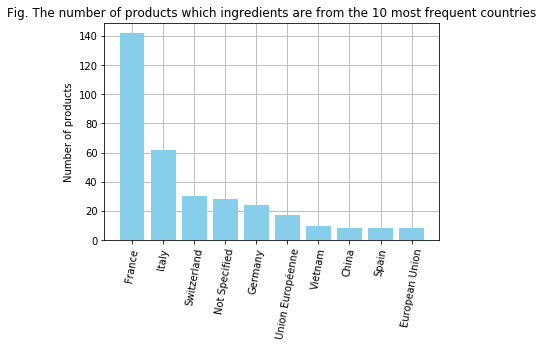

In [129]:
# Extract the 10 most important countries and number of occurances in ingredients.
origin_countries = target_origins.toPandas() 
origin_countries = origin_countries.head(10)

# Plot the number of products imported by 10 most important countries
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.bar(origin_countries.origins, origin_countries.Count, zorder=3, color='skyblue')
plt.ylabel('Number of products')   
plt.xticks(origin_countries.origins, rotation='80')
plt.title('Fig. The number of products which ingredients are from the 10 most frequent countries')
plt.show()

In [103]:
# Export origins to CSV 
target_origins.select("origins").toPandas().to_csv('output/origins.csv')

Now that we found the most important countries in case of producing ingredients for products which are imported to Switzerland, We should take the same approach to find the most important manufacturers of this products.

In [130]:
# Flatten manufacturing_places column
manufacturers_p = non_swiss_sold.withColumn('manufacturing_places', F.explode_outer(F.split('manufacturing_places', ',')))

# Clean manufacturers countries
for index, row in cleaned_countries.iterrows():
    if(str(row['replace_with']) != "nan"):
        manufacturers_p = manufacturers_p.withColumn('manufacturing_places', F.regexp_replace('manufacturing_places', "^" + row['origins'] + "$", row['replace_with']))
    else:
        manufacturers_p = manufacturers_p.withColumn('manufacturing_places', F.regexp_replace('manufacturing_places', row['origins'], "Not Specified"))


In [131]:
# Find dominant importers (manufacturers)

manufacturers_p.createOrReplaceTempView("manufacturers_p")
target_manufacturers = spark.sql("SELECT manufacturing_places, COUNT(manufacturing_places) FROM manufacturers_p GROUP BY manufacturing_places ORDER BY COUNT(manufacturing_places) DESC")
target_manufacturers = target_manufacturers.withColumnRenamed('count(manufacturing_places)' , 'Count')
# target_manufacturers.show()

print("Number of Manufacturers:\n" + str(target_manufacturers.count()))

Number of Manufacturers:
278


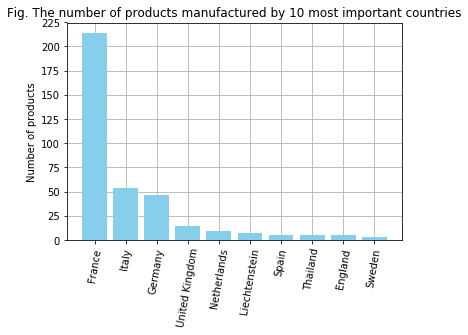

In [132]:
# Extract the 10 most important manufacturers countries and number of occurances.
manufacturer_countries = target_manufacturers.toPandas() 
manufacturer_countries = manufacturer_countries.head(10)

# Plot the number of products manufactured by 10 most important countries
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.bar(manufacturer_countries.manufacturing_places, manufacturer_countries.Count, zorder=3, color='skyblue')
plt.ylabel('Number of products')   
plt.xticks(manufacturer_countries.manufacturing_places, rotation='80')
plt.title('Fig. The number of products manufactured by 10 most important countries')
plt.show()

In [125]:
# Export manufacturing_places to CSV 
target_manufacturers.select("manufacturing_places").toPandas().to_csv('output/manufacturing_places.csv')

### Working with products' categories

We would like to find which countries import what products?
In order to answer to this question, first we extract categories corresponding to the products sold in Switzerland but not manufactured in this country. Then we will combine the information provided for manufacturing places of these products with corresponding category. 

In the end we will extract the 5 most important importers of each category.

In [134]:
extra_info_df = ' categories '
categories_df = spark.sql("SELECT" + p_id_col + extra_info_df + " FROM data_main")
categories_df.show(10)

+-------------+--------------------+----------+
|         code|        product_name|categories|
+-------------+--------------------+----------+
|0000000000017|    Vitória crackers|      null|
|0000000000031|               Cacao|      null|
|0000000000123|Sauce Sweety chil...|      null|
|0000000000291|           Mendiants|      null|
|0000000000949|Salade de carotte...|      null|
|0000000000970|Fromage blanc aux...|      null|
|0000000001001|                null|      null|
|0000000001007|            Vainilla|      null|
|0000000001137|   Baguette parisien|      null|
|0000000001151|&quot;Baguette Ly...|      null|
+-------------+--------------------+----------+
only showing top 10 rows



In [135]:
categories_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in traces_df.columns]).show()

+----+------------+----------+
|code|product_name|categories|
+----+------------+----------+
|   0|       25982|    514895|
+----+------------+----------+



In [136]:
# Join table of categories with table of target products (Sold in Switzerland but not manufactured in it)
non_swiss_sold.createOrReplaceTempView("target_products_df")
categories_df.createOrReplaceTempView("categories_df")
joined_df = spark.sql("SELECT p.code, c.categories, p.origins, p.manufacturing_places, p.countries  FROM target_products_df p INNER JOIN categories_df c ON p.code = c.code")

In [137]:
joined_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in joined_df.columns]).show()

+----+----------+-------+--------------------+---------+
|code|categories|origins|manufacturing_places|countries|
+----+----------+-------+--------------------+---------+
|   0|        15|      0|                   0|        0|
+----+----------+-------+--------------------+---------+



According to above table, just 15 products do not have category. 

In [138]:
joined_df.createOrReplaceTempView("target_products_cats")
sql_filter = "SELECT * FROM target_products_cats WHERE categories is not NULL"
target_products_categories_p = spark.sql(sql_filter)

print("Number of Products sold in Switzerland with categories:\n" + str(target_products_categories_p.count()))

Number of Products sold in Switzerland with categories:
358


In [139]:
target_products_categories_p.show(5)

+-------------+--------------------+--------------------+--------------------+--------------------+
|         code|          categories|             origins|manufacturing_places|           countries|
+-------------+--------------------+--------------------+--------------------+--------------------+
|4104420209114|Snacks sucrés,Bis...|Agriculture UE/No...|            Pays-Bas|    Allemagne,Suisse|
|7613331285263|    Nectar de fruits|Bulgarie,Roumanie...|           Allemagne|              Suisse|
|8076809513388|Epicerie,Sauces,S...|Italie,Tomates d'...|BARILLA ALIMENTAR...|Autriche,France,A...|
|9310055917996|Rice Crackers,Sna...|United States,Imp...|       United States|Australia, en:fra...|
|3256540011465|Snacks sucrés,Vie...|              France|              France|       France,Suisse|
+-------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [44]:
# Flatten categories column
target_products_categories_p = target_products_categories_p.withColumn('categories', F.explode_outer(F.split('categories', ',')))

# Remove occurances of en: in name of categories
target_products_categories_p = target_products_categories_p.withColumn('categories', F.regexp_replace('categories', 'en:', ''))

target_products_categories_p.show(5)

+-------------+-------------------+--------------------+--------------------+----------------+
|         code|         categories|             origins|manufacturing_places|       countries|
+-------------+-------------------+--------------------+--------------------+----------------+
|4104420209114|      Snacks sucrés|Agriculture UE/No...|            Pays-Bas|Allemagne,Suisse|
|4104420209114|Biscuits et gâteaux|Agriculture UE/No...|            Pays-Bas|Allemagne,Suisse|
|4104420209114|        Pâtisseries|Agriculture UE/No...|            Pays-Bas|Allemagne,Suisse|
|4104420209114|            Gaufres|Agriculture UE/No...|            Pays-Bas|Allemagne,Suisse|
|7613331285263|   Nectar de fruits|Bulgarie,Roumanie...|           Allemagne|          Suisse|
+-------------+-------------------+--------------------+--------------------+----------------+
only showing top 5 rows



In [24]:
# Find dominant categories
target_products_categories_p.createOrReplaceTempView("target_products_categories_p")
target_categories = spark.sql("SELECT categories, COUNT(categories) FROM target_products_categories_p GROUP BY categories ORDER BY COUNT(categories) DESC")
target_categories = target_categories.withColumnRenamed('count(categories)' , 'Count')
target_categories.show()

print("Number of Categories:\n" + str(target_categories.count()))

+--------------------+-----+
|          categories|Count|
+--------------------+-----+
|   Produits laitiers|   41|
|Aliments et boiss...|   40|
|Aliments d'origin...|   37|
|               Frais|   33|
|            Boissons|   31|
|            Fromages|   28|
|  Produits fermentés|   19|
|      Plats préparés|   18|
|Fromages pasteurisés|   17|
|   Fromages de vache|   16|
|Produits laitiers...|   16|
|Fromages industriels|   15|
|Boissons non sucrées|   15|
|  Fromages de France|   13|
|            Desserts|   13|
|Céréales et pomme...|   13|
|  Produits de la mer|   12|
|     Petit-déjeuners|   12|
|            Poissons|   11|
|       Snacks sucrés|   11|
+--------------------+-----+
only showing top 20 rows

Number of Categories:
831


According to above table not all categories are independant and they may contain similar products. We did not change categories for this milestone but we would like to merge some categories in future to have better distinction between countries which import these products. 

In [25]:
# Export Categories to CSV 
target_categories.toPandas().to_csv('output/categories.csv')

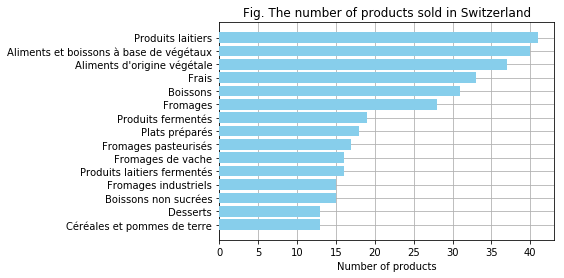

In [140]:
# Extract the 15 most frequent categories and number of occurances.
categories = target_categories.toPandas() 
categories = categories.head(15)

# Plot the most frequent categories
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.barh(categories.categories, categories.Count, zorder=3, color='skyblue')
plt.xlabel('Number of products')   
plt.title('Fig. The number of products sold in Switzerland')
ax.invert_yaxis() 
plt.show()

In [149]:
cleaned_countries = pd.read_csv("cleaning_data/origins_cleaning.csv")

In [154]:
# Extract the most important manufacturer countries for 15 most frequent categories

categories_countires_p = target_products_categories_p.withColumn('manufacturing_places', F.explode_outer(F.split('manufacturing_places', ',')))

# Clean manufacturers countries
for index, row in cleaned_countries.iterrows():
    if(str(row['replace_with']) != "nan"):
        categories_countires_p = categories_countires_p.withColumn('manufacturing_places', F.regexp_replace('manufacturing_places', "^" + row['origins'] + "$", row['replace_with']))
    else:
        categories_countires_p = categories_countires_p.withColumn('manufacturing_places', F.regexp_replace('manufacturing_places', row['origins'], "Not Specified"))

categories_countires_p = categories_countires_p.withColumn('categories', F.explode_outer(F.split('categories', ',')))
products_cats_df = categories_countires_p.toPandas()

countries_cats = []
cat = "Snacks sucrés"
for index, row in categories.iterrows():
    temp_df = products_cats_df[(products_cats_df.categories == row.categories)].groupby('manufacturing_places').count().sort_values(by=['code'], ascending=False).head(5)
    countries_cats.append(temp_df)

# Each element of countries_cats is a dataframe containing the most important manufacturers
# of the corresponding category

i = 0
print("category: " + str(categories.iloc[i].categories))
print("The most important manufacturers:")
print(countries_cats[0].head(3).index.values)

category: Produits laitiers
The most important manufacturers:
['France' 'Italy' 'United Kingdom']


We will use extracted information about the most important manufacturer countries for 15 most frequent categories for our visualization.

## Descriptive Analysis

In [3]:
openfood = pd.read_csv(DATA_FOLDER + openfood_file, sep = '\t')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,3,5,24,25,26,28,36,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
foodSwitzerland = openfood[openfood['countries_tags']=="en:switzerland"]

In [5]:
nbProdSwit = len(foodSwitzerland)
print("Number of products: ", nbProdSwit)

Number of products:  13454


# first perspective: Compare old vs new products inside the dataset

A product in the dataset is considered "old" if its description was uploaded to the dataset before February 2017. By the contrary, it is considered as "new" if its description was uploaded after that date.

_As that definition is a little rigid, in order to get closer to the real situation, the following assumption is made: From the total products uploaded to the dataset after February 2017, 20% are old products._  

A first perspective to tackle the research question, is to compare how in this more than 6 years of existance of the dataset, the characteristics of the products have changed. Specifically, we would like to know if there have been some changes in the origin of the primary resources, or in the origin of the manufacture or in the labels of the products.

The study of the evolution in time of each one of those features, will include an __exploratory data analysis__.
Finally, a study including the three features will be done, aiming to find an aggregated differentiated behavior in time, reflected in different clusters of periods of time. For that the __K-modes algorithm__ will be used.

In [6]:
print("Date of first upload: ", min(foodSwitzerland['created_datetime']))
print("Date of last upload retrieved: ", max(foodSwitzerland['created_datetime']))

Date of first upload:  2012-05-16T18:33:35Z
Date of last upload retrieved:  2018-11-23T08:40:49Z


In [7]:
foodSwitzerland['created_datetime'] = pd.to_datetime(foodSwitzerland['created_datetime'])
foodSwitzerland = foodSwitzerland.sort_values(by='created_datetime')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


The uploads of products sold in Switzerland, behaves differently in time. Taking into account the histogram presented below, two periods of time are defined:
- Period 1: Created for studying the behaviour from "old" products. Products uploaded before Feb 2017.
- Period 2: Created for studying the behaviour from "new" products. Products uploaded after Feb 2017.

Old products:  11826.8
New products:  1627.2


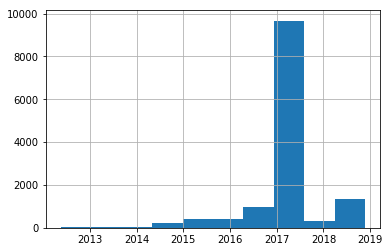

In [8]:
rateOldInNew = 0.2
old_products = len(foodSwitzerland[foodSwitzerland['created_datetime']<"2017-03-01 00:00:00"])
print("Old products: ", old_products + (len(foodSwitzerland)-old_products)*(rateOldInNew))
print("New products: ", (len(foodSwitzerland)-old_products)*(1-rateOldInNew))
foodSwitzerland['created_datetime'].hist()

Before making subdivision of data:

In [9]:
filter_ch = '[Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra'
filter_local = '[Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra|[Ll]ocal'

place = pd.Series(['Other country','Switzerland', 'No information'], index=[0,1,2])
refLabel = pd.Series(['Other Label','Related with Switzerland', 'No information'], index=[0,1,2]) 

foodSwitzerland["originsCat"] = foodSwitzerland["origins"].str.contains(filter_ch,regex=True).map(place,na_action='ignore')
foodSwitzerland["manuCat"] = foodSwitzerland["manufacturing_places"].str.contains(filter_ch,regex=True).map(place,na_action='ignore')
foodSwitzerland["labCat"] = foodSwitzerland["labels_tags"].str.contains(filter_local,regex=True).map(refLabel,na_action='ignore')

Now, let's do the subdivision in the two periods, taking care of our assumption of 20%:

In [10]:
foodSwitzerlandBef = foodSwitzerland[foodSwitzerland['created_datetime']<"2017-03-01 00:00:00"]
foodSwitzerlandAft = foodSwitzerland[foodSwitzerland['created_datetime']>="2017-03-01 00:00:00"]

befInAft = foodSwitzerlandAft.sample(n=int(rateOldInNew*len(foodSwitzerlandAft)), replace=False)
foodSwitzerlandBef = pd.concat([foodSwitzerlandBef,befInAft],axis=0)

for i in range (0,len(befInAft)):
    foodSwitzerlandAft = foodSwitzerlandAft[foodSwitzerlandAft['code']!=befInAft['code'].iloc[i]]
print("Number of Old products: ", np.shape(foodSwitzerlandBef))
print("Number of New products: ", np.shape(foodSwitzerlandAft))

Number of Old products:  (11826, 176)
Number of New products:  (1627, 176)


### 2.1 Study of the evolution in time of each one of the interest features

### 2.1.1 With respect to: Origin of the primary resources

First, bootstrapping for include confidence intervals to results

In [11]:
#before
propSB_100ite = np.zeros (100)
propOCB_100ite = np.zeros (100)
#after
propSA_100ite = np.zeros (100)
propOCA_100ite = np.zeros (100)

for iteration in range(0,100):
    #before
    temp_bef = foodSwitzerlandBef["originsCat"].sample(n=len(foodSwitzerlandBef), replace=True)
    propSB_100ite[iteration] = (sum(temp_bef=="Switzerland")/len(foodSwitzerlandBef))
    propOCB_100ite[iteration] = sum(temp_bef=="Other country")/len(foodSwitzerlandBef)
    #after
    temp_aft = foodSwitzerlandAft["originsCat"].sample(n=len(foodSwitzerlandAft), replace=True)
    propSA_100ite[iteration] = sum(temp_aft=="Switzerland")/len(foodSwitzerlandAft)
    propOCA_100ite[iteration] = sum(temp_aft=="Other country")/len(foodSwitzerlandAft)
    
    #Relation of time evolution and difference of products in each categories
    difpropB = propSB_100ite[iteration]-propOCB_100ite[iteration]
    difpropA = propSB_100ite[iteration]-propOCA_100ite[iteration]

#Calculating standard deviation of count of each category
SBstd = np.std(propSB_100ite)
OCBstd = np.std(propOCB_100ite)
#Calculating standard deviation of count of each category
SAstd = propSA_100ite.std()
OCAstd = propOCA_100ite.std()

Then, plotting of behavior 

There was not information for  11166  products in the period 1.
There was not information for  1545  products in the period 2.


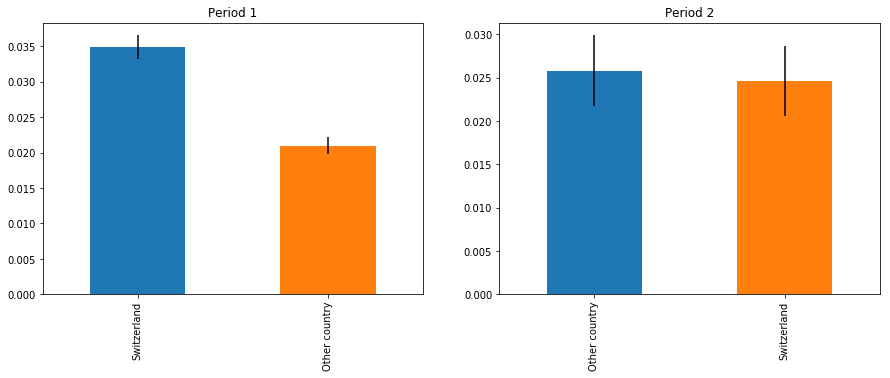

In [12]:
#Report information of NAN cases
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
print("There was not information for ",len(foodSwitzerlandBef["originsCat"])-sum(foodSwitzerlandBef["originsCat"]=="Switzerland")-sum(foodSwitzerlandBef["originsCat"]=="Other country")," products in the period 1.")
print("There was not information for ",len(foodSwitzerlandAft["originsCat"])-sum(foodSwitzerlandAft["originsCat"]=="Switzerland")-sum(foodSwitzerlandAft["originsCat"]=="Other country")," products in the period 2.")

#Plot origin of primary resources by periods
plt.subplot(1,2,1)
(foodSwitzerlandBef["originsCat"].value_counts()/len(foodSwitzerlandBef["originsCat"])).plot(kind='bar', yerr = [SBstd,OCBstd],title='Period 1')
plt.subplot(1,2,2)
(foodSwitzerlandAft["originsCat"].value_counts()/len(foodSwitzerlandAft["originsCat"])).plot(kind='bar', yerr = [SAstd,OCAstd],title='Period 2')

plt.show()

Most of old products have as origin of primary resources Switzerland. However, in new products, the origin of primary resources is for Switzerland and Other countries statistically the same.

### 2.1.2 With respect to: Manufacture

First, bootstrapping for include confidence intervals to results

In [13]:
#before
propSB_100ite = np.zeros (100)
propOCB_100ite = np.zeros (100)

#after
propSA_100ite = np.zeros (100)
propOCA_100ite = np.zeros (100)

for iteration in range(0,100):
    #before
    temp_bef = foodSwitzerlandBef["manuCat"].sample(n=len(foodSwitzerlandBef), replace=True)
    propSB_100ite[iteration] = sum(temp_bef=="Switzerland")/len(foodSwitzerlandBef)
    propOCB_100ite[iteration] = sum(temp_bef=="Other country")/len(foodSwitzerlandBef)
    #after
    temp_aft = foodSwitzerlandAft["manuCat"].sample(n=len(foodSwitzerlandAft), replace=True)
    propSA_100ite[iteration] = sum(temp_aft=="Switzerland")/len(foodSwitzerlandAft)
    propOCA_100ite[iteration] = sum(temp_aft=="Other country")/len(foodSwitzerlandAft)
    

#Calculating standard deviation of count of each category
SBstd = propSB_100ite.std()
OCBstd = propOCB_100ite.std()
#Calculating standard deviation of count of each category
SAstd = propSA_100ite.std()
OCAstd = propOCA_100ite.std()

There was not information for  10862  products in the period 1.
There was not information for  1496  products in the period 2.


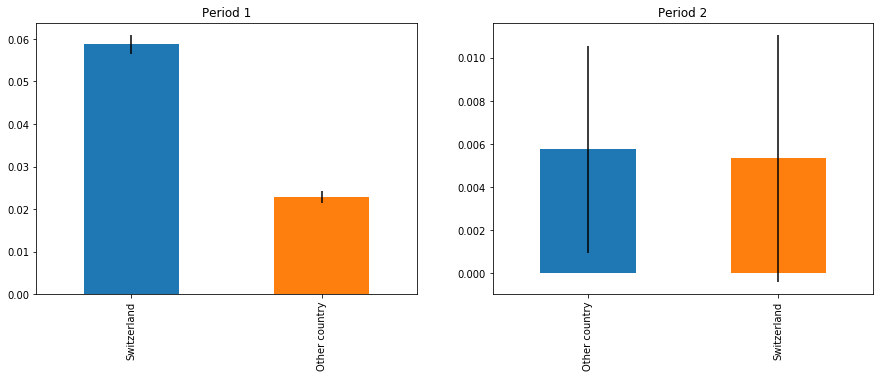

In [14]:
#Report information of NAN cases
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
print("There was not information for ",len(foodSwitzerlandBef["manuCat"])-sum(foodSwitzerlandBef["manuCat"]=="Switzerland")-sum(foodSwitzerlandBef["manuCat"]=="Other country")," products in the period 1.")
print("There was not information for ",len(foodSwitzerlandAft["manuCat"])-sum(foodSwitzerlandAft["manuCat"]=="Switzerland")-sum(foodSwitzerlandAft["manuCat"]=="Other country")," products in the period 2.")

#Plot origin of primary resources by periods
plt.subplot(1,2,1)
(foodSwitzerlandBef["manuCat"].value_counts()/len(foodSwitzerlandBef["manuCat"])).plot(kind='bar', yerr = [SBstd,OCBstd],title='Period 1')
plt.subplot(1,2,2)
(foodSwitzerlandAft["manuCat"].value_counts()/len(foodSwitzerlandBef["manuCat"])).plot(kind='bar', yerr = [SAstd,OCAstd],title='Period 2')

plt.show()

Most of old products were manufactured in Switzerland. However, in new products, the manufacture is for Switzerland and Other countries statistically the same.

### 2.1.3 With respect to: Labels

In [15]:
#before
propSB_100ite = np.zeros (100)
propOCB_100ite = np.zeros (100)
#after
propSA_100ite = np.zeros (100)
propOCA_100ite = np.zeros (100)

for iteration in range(0,100):
    #before
    temp_bef = foodSwitzerlandBef["labCat"].sample(n=len(foodSwitzerlandBef), replace=True)
    propSB_100ite[iteration] = sum(temp_bef=="Related with Switzerland")/len(foodSwitzerlandBef)
    propOCB_100ite[iteration] = sum(temp_bef=="Other Label")/len(foodSwitzerlandBef)
    #after
    temp_aft = foodSwitzerlandAft["labCat"].sample(n=len(foodSwitzerlandAft), replace=True)
    propSA_100ite[iteration] = sum(temp_aft=="Related with Switzerland")/len(foodSwitzerlandAft)
    propOCA_100ite[iteration] = sum(temp_aft=="Other Label")/len(foodSwitzerlandAft)
    
    #Relation of time evolution and difference of products in each categories
    difpropB = propSB_100ite[iteration]-propOCB_100ite[iteration]
    difpropA = propSB_100ite[iteration]-propOCA_100ite[iteration]

#Calculating standard deviation of count of each category
SBstd = propSB_100ite.std()
OCBstd = propOCB_100ite.std()
#Calculating standard deviation of count of each category
SAstd = propSA_100ite.std()
OCAstd = propOCA_100ite.std()

There was not information for  11826  products in the period 1.
There was not information for  1627  products in the period 2.


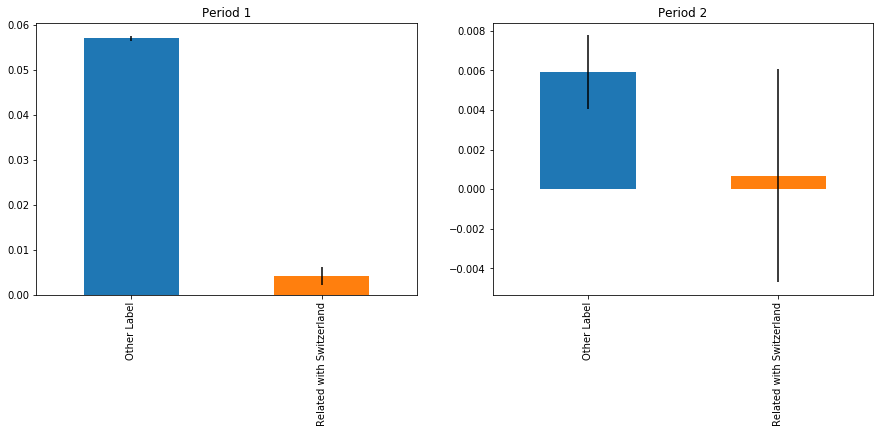

In [16]:
#Report information of NAN cases
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
print("There was not information for ",len(foodSwitzerlandBef["labCat"])-sum(foodSwitzerlandBef["labCat"]=="Switzerland")-sum(foodSwitzerlandBef["labCat"]=="Other country")," products in the period 1.")
print("There was not information for ",len(foodSwitzerlandAft["labCat"])-sum(foodSwitzerlandAft["labCat"]=="Switzerland")-sum(foodSwitzerlandAft["labCat"]=="Other country")," products in the period 2.")

#Plot origin of primary resources by periods
plt.subplot(1,2,1)
(foodSwitzerlandBef["labCat"].value_counts()/len(foodSwitzerlandBef["labCat"])).plot(kind='bar', yerr = [SBstd,OCBstd],title='Period 1')
plt.subplot(1,2,2)
(foodSwitzerlandAft["labCat"].value_counts()/len(foodSwitzerlandBef["labCat"])).plot(kind='bar', yerr = [SAstd,OCAstd],title='Period 2')

plt.show()

For the two periods studied, other labels are more frequent than the related with Switzerland

## Future plan

### Improving data cleaning for countries 

Although we cleaned the data of name of countries but about 200 are still remained.

### Extend research questions to Europe

After talking with TA, we decided to extend our research questions to Europe in order to have more data. The similar approach will be taken for answering our main questions about Europe.

### Evaluate and complement our results

We would like to complement our results using following databases:
- Additional datasets “Evolution de la consommation de denrées alimentaires en Suisse” (https://opendata.swiss/fr/dataset/entwicklung-des-nahrungsmittelverbrauches-in-der-schweiz-je-kopf-und-jahr1) and “Dépenses fédérales pour l’agriculture et l’alimentation” (https://opendata.swiss/fr/dataset/bundesausgaben-fur-die-landwirtschaft-und-die-ernahrung1) from https://opendata.swiss/fr/group/agriculture

- A last additional dataset for the second question of the project https://www.gate.ezv.admin.ch/swissimpex/public/bereiche/waren/result.xhtml Total of imports of agriculture, forestry and fishing goods

### Find the most important characteristic of Swiss-made products

After answering our main research questions we would like to find which products are likely to import to Switzerland. To answer this question we would like to train a classifier in order to see which features are the most important features to decide if a product is Swiss made or not.

### Improve our assumption about date of entering products to the Swiss market

Study of the evolution in time of the interest features combined
- The k-modes and other machine learning algorithms are expected to be done for the milestone 3.